In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [40]:
# Load preprocessed data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

y_output = to_categorical(y_output, num_classes=4)

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_input, y_output, test_size=0.2, random_state=42)

# Initialize DenseNet121 base
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best performing model to a checkpoint
checkpoint_DenseNet = ModelCheckpoint('model_checkpoints/DenseNet_brain_tumor.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Stop training model if no improvement in loss value after 10 epochs
early_stopping_DenseNet = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [45]:
# Train Model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_DenseNet, early_stopping_DenseNet]
)


Epoch 1/50


In [35]:
def plot_metrics(history):
    # Plot Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model):
    """Evaluate a trained model on test data and display the confusion matrix and classification report."""
    # Class labels
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # Predict the labels for the test data
    predictions = model.predict(x_val)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_val, axis=1)
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Print the classification report using tabulate
    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("Classification Report:")
    print(tabulate(report_df, headers='keys', tablefmt='pretty'))


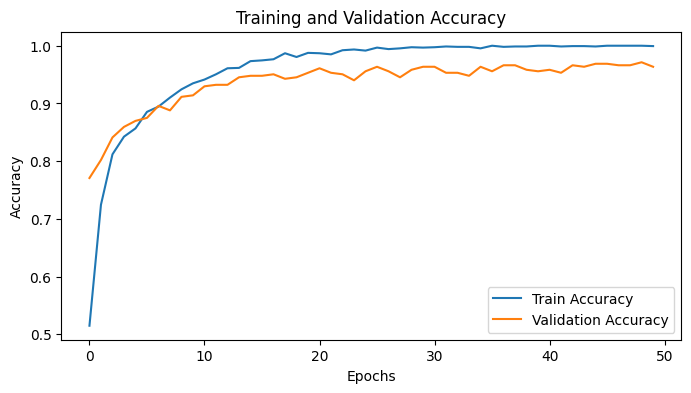

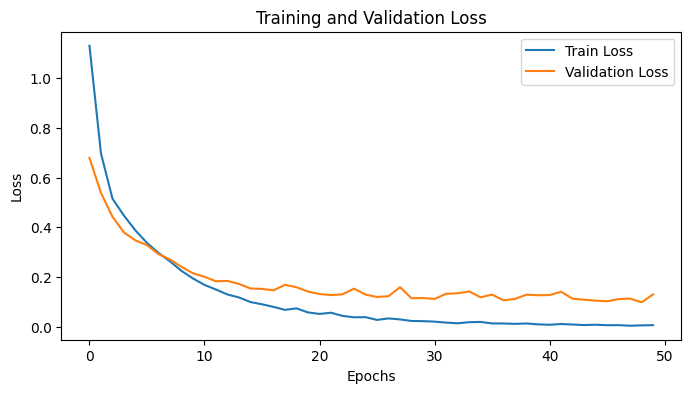

12/12 [==============================] - 15s 1s/step


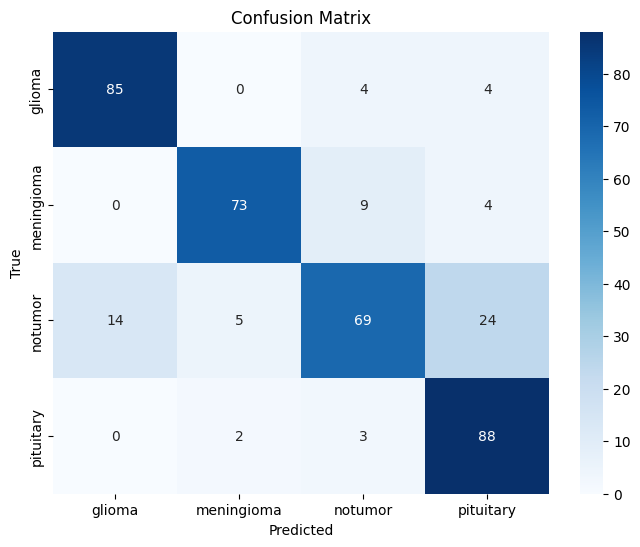

Classification Report:
+--------------+--------------------+--------------------+--------------------+-----------+
|              |     precision      |       recall       |      f1-score      |  support  |
+--------------+--------------------+--------------------+--------------------+-----------+
|    glioma    | 0.8585858585858586 | 0.9139784946236559 | 0.8854166666666665 |   93.0    |
|  meningioma  |       0.9125       | 0.8488372093023255 | 0.8795180722891567 |   86.0    |
|   notumor    | 0.8117647058823529 | 0.6160714285714286 | 0.700507614213198  |   112.0   |
|  pituitary   | 0.7333333333333333 | 0.946236559139785  | 0.8262910798122065 |   93.0    |
|   accuracy   |     0.8203125      |     0.8203125      |     0.8203125      | 0.8203125 |
|  macro avg   | 0.8290459744503862 | 0.8312809229092988 | 0.8229333582453069 |   384.0   |
| weighted avg | 0.8266696143419489 |     0.8203125      | 0.8158443422689606 |   384.0   |
+--------------+--------------------+--------------------

In [44]:
# Print Accuracy graph, Loss graph, Confusion Matrix and Classification Report
plot_metrics(history)
best_densenetModel = load_model('model_checkpoints/DenseNet_brain_tumor.keras')
plot_confusion_matrix(best_densenetModel)
